# Documentation du Module AssistEye

Ce notebook présente la documentation complète du module **AssistEye**. Vous y trouverez :

- Une **introduction** présentant les objectifs et les fonctionnalités (détection d’objets, estimation de profondeur, détection de texte, traduction et assistance vocale).
- La **structure du projet** et la description de la configuration.
- Des **exemples d’utilisation** pour chacun des modules.
- Des indications pour démarrer l’**API** et mettre à jour la configuration.

## Objectifs et Fonctionnalités

- **Détection d'objets** : Utilisation de modèles YOLO pour identifier des objets dans une image ou une vidéo.
- **Estimation de profondeur** : Calcul de la distance des objets grâce à la carte de profondeur.
- **Détection de texte** : Extraction de texte présent sur une image à l’aide de Tesseract.
- **Traduction** : Traduction des labels et formulation de réponses dans différentes langues.
- **Assistance vocale** : Interaction par commande vocale (écoute, reconnaissance et réponse via synthèse vocale).
- **Visualisation** : Affichage des résultats annotés sur les images ou vidéos.

## Prérequis

- Python 3.x
- Installation des dépendances via `pip install -r requirements.txt`
- Tesseract installé pour la détection de texte

## Configuration

Le fichier `default.yaml` (dans le dossier `config`) définit les paramètres par défaut :

- Les noms des modèles pour la détection, la profondeur et le texte
- Le seuil de confiance pour la détection
- La langue utilisée pour les réponses et les traductions

Vous pouvez modifier ces paramètres ou créer un fichier `custom.yaml` pour personnaliser la configuration.

In [1]:
import sys
import os

# Méthode d'indexation des modules AssistEye pour pouvoir les utiliser en dehors du dossier src
def configure():
    sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))
    print('Chemins de recherche ajoutés:', sys.path)

configure()

Chemins de recherche ajoutés: ['/opt/anaconda3/envs/assisteye/lib/python39.zip', '/opt/anaconda3/envs/assisteye/lib/python3.9', '/opt/anaconda3/envs/assisteye/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/assisteye/lib/python3.9/site-packages', '/opt/anaconda3/envs/assisteye/lib/python3.9/site-packages/setuptools/_vendor', '/Users/quentinpierson/Documents/AssistEye/src']


## Exemple : Chargement et Détection d'une Image avec annotations

Cet exemple montre comment lancer l'inférence sur une image statique afin d'afficher les annotations (classe, confiance et distance) sur l'image.

AssistEye config loaded successfully.
Initializing object detection model...
Model: yolo11n.pt, Device: mps


Using cache found in /Users/quentinpierson/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/quentinpierson/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


AssistEye module loaded successfully.

0: 640x480 4 persons, 1 bus, 410.8ms
Speed: 12.5ms preprocess, 410.8ms inference, 118.8ms postprocess per image at shape (1, 3, 640, 480)


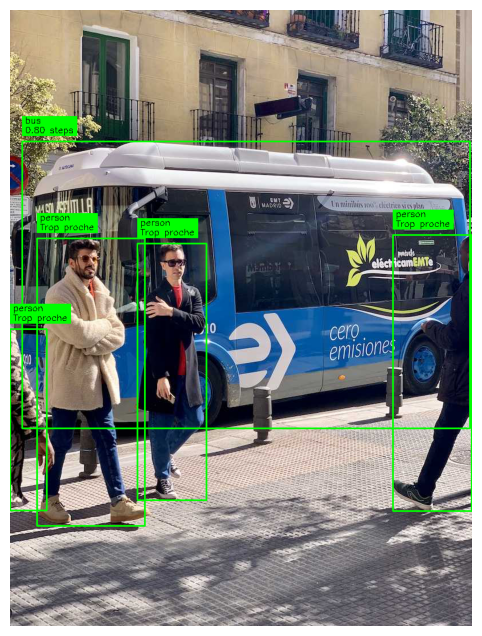

In [2]:
from AssistEye.detection import objectDetection

# Chemin de l'image et configuration des annotations
image_path = '../data/bus.jpg'
annotations = {
    'class': True,
    'confidence': False,
    'distance': True,
}

# Lancement de l'inférence sur l'image
objectDetection.run_inference(image_path, annotations)

## Exemple : Chargement et Détection d'une Vidéo avec annotations

Cet exemple illustre le traitement d'une vidéo en temps réel en affichant les annotations sur chaque frame.

In [ ]:
# Chemin de la vidéo
video_path = '../data/ville.mp4'

# Lancement de l'inférence sur la vidéo
objectDetection.run_inference(video_path, annotations)

## Exemple : Détection de texte sur un objet détecté

Dans cet exemple, nous détectons des objets dans une image, recadrons la région d'intérêt et effectuons la détection de texte sur cette région.

Image originale:


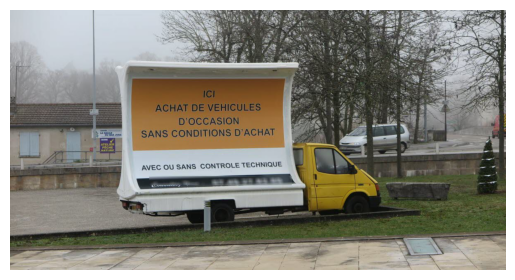


0: 352x640 1 car, 2 trucks, 451.6ms
Speed: 13.9ms preprocess, 451.6ms inference, 186.4ms postprocess per image at shape (1, 3, 352, 640)
Classes détectées: {'truck': 2, 'car': 1}
Positions: {'truck': [(258, 125, 896, 522), (258, 321, 898, 524)], 'car': [(795, 275, 968, 351)]}
Traitement de la première région pour la classe 'truck'...
Image recadrée:


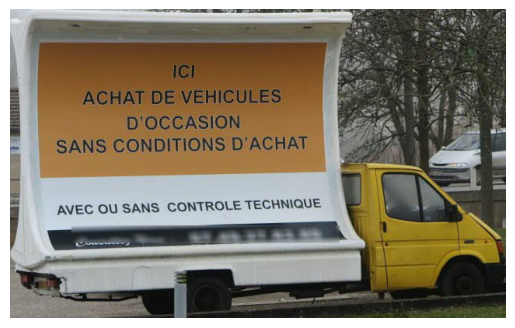

Détection de texte sur l'image recadrée:
Texte détecté: ['AVEC', 'OU', 'SANS', 'CONTROLE', 'TECHNIQUE', '']
Inference sur l'image recadrée avec détection de texte:


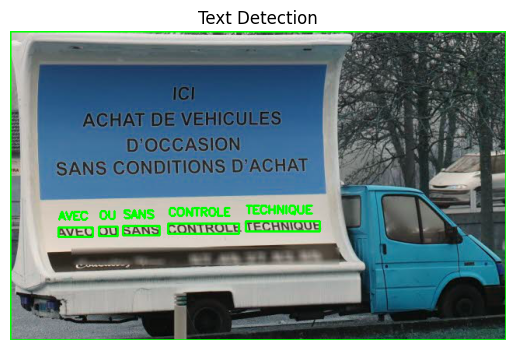

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from AssistEye.detection import objectDetection, textDetection

# Chargement de l'image
image_path = '../data/truck.jpg'
image = np.array(Image.open(image_path))

# Affichage de l'image originale
print("Image originale:")
plt.imshow(image)
plt.axis('off')
plt.show()

# Détection d'objets
results = objectDetection.detect(image)
object_counts, distances, positions = objectDetection.process_results(results, depth_map_normalized=None, return_positions=True)

print("Classes détectées:", object_counts)
print("Positions:", positions)

# Recadrage de la première région détectée
cropped_regions = objectDetection.crop_objects(image, positions)

if cropped_regions:
    for class_name, crops in cropped_regions.items():
        if crops:  # S'assurer que la liste n'est pas vide
            first_cropped_region = crops[0]
            print(f"Traitement de la première région pour la classe '{class_name}'...")
            break
else:
    print("Aucune région recadrée trouvée.")

# Affichage de l'image recadrée
print("Image recadrée:")
plt.imshow(first_cropped_region)
plt.axis('off')
plt.show()

# Détection de texte sur l'image recadrée
print("Détection de texte sur l'image recadrée:")
text_results = textDetection.detect(first_cropped_region)
detected_text, text_positions = textDetection.process_results(text_results)

print("Texte détecté:", detected_text)

annotations = {
    'class': True,
    'confidence': True
}

# Exécution de l'inférence avec détection de texte
print("Inference sur l'image recadrée avec détection de texte:")
textDetection.run_inference(first_cropped_region, annotations)

## Configuration des Modules

Ici, nous initialisons le module de détection avec une configuration personnalisée (modèle et dispositif).

In [ ]:
from ultralytics import YOLO
from AssistEye import detection
from AssistEye.detection import objectDetection

# Initialisation avec un modèle personnalisé
model_name = 'yolo8n.pt'  # Modèle personnalisé
device_name = 'mps'      # Dispositif personnalisé (cpu, cuda, mps)

objectDetection.initialization(model_name, device_name)

image = 'bus.jpg'

# Lancement de l'inférence
objectDetection.run_inference(image, annotations)

## Utilisation du Bandeau de Débogage

Le bandeau de débogage fournit des informations utiles (par exemple, le temps de traitement, les paramètres utilisés, etc.) pour le diagnostic durant le développement.

In [4]:
from AssistEye import debug

# Génération et affichage des informations de débogage
debug_info = debug.generate_debug_info(results)
print(debug_info)

AttributeError: module 'AssistEye.debug' has no attribute 'generate_debug_info'

## Utilisation de l'API AssistEye

L'API permet d'accéder aux fonctionnalités de détection et de reconnaissance via des requêtes HTTP. Vous pouvez la démarrer et l'utiliser par exemple avec Postman ou un navigateur.

In [ ]:
from AssistEye import api
from AssistEye.config import config

# Initialisation de l'API
api.api_init()
api.run_api()

## Utilisation des Commandes Vocales

Le module Voice Assistant permet d'interagir par la voix. Il écoute une commande, la reconnaît et y répond via la synthèse vocale.

Cet exemple n'est ici qu'une démonstration : dans une application réelle, les commandes seraient gérées de manière plus dynamique.

## Mise à jour d'un Paramètre de Configuration

Cet exemple illustre comment mettre à jour un paramètre (ici la langue) dans le fichier de configuration et obtenir une confirmation.

In [ ]:
from AssistEye import config

# Mise à jour du paramètre 'language' dans la section 'general'
message = config.update_config_param('general', 'language', 'en')
print(message)

## Conclusion

Ce notebook a présenté une documentation complète du module **AssistEye** en couvrant les aspects suivants :

- Détection d'objets et estimation de profondeur
- Détection de texte et recadrage d'images
- Configuration et initialisation des modules
- Démarrage de l'API et utilisation des commandes vocales

Utilisez ces exemples comme point de départ pour intégrer et étendre les fonctionnalités d’AssistEye dans vos projets.

Pour toute question ou amélioration, consultez la documentation du code source et n'hésitez pas à contribuer.